In [26]:
%run ./resources/library.py
style_notebook()

# Notebook 4: Analyzing the John Snow Cholera Outbreak Using OpenStreetMaps and Networkx - Part 2

## Learning Objectives

By the end of this notebook, you should be able to:

1. Recall how to load and save `osmnx` street network graphs 
2. Recall how to load data from CSV using `pandas`
3. Describe how the three distances, d1, d2 and d3, are computed using `osmnx`
4. Describe how a nested loop works to calculate the route distance between 2 nodes (pumps and deaths)
5. Identify how this algorithm pattern can be used in solving other public health problems.

## Summary of steps

We will carry out the following <font color=red>steps</font>:

<font color=red>Step 1</font> - Read the street network graph, `G`, of Soho district using OSMnx using a set of coordinates in the middle of Soho district. **(We saved this graph in Notebook 2 and we will read it from the graphml file `soho.graphml`.)**  
   
   
<font color=red>Step 2</font> - Load the original data sets from Notebook 1 (pumps and deaths) into `pumps_df` and `deaths_df`.


<font color=red>Step 3</font> - To represent coordinates from the pumps and deaths from the Notebook 1 in OSMnx graph format, we have to find the nearest OSMnx nodes to those points. We will add new columns to the pumps and deaths dataframes to accomodate new information coming from OSMnx. We will also store the short distances between original points to the nearest OSMnx points and store it in the respective dataframes.

<font color=red>Step 4</font> -  To calculate mean distances from death coordinates to pump coordinates we will create a nested loop through records of both dataframes, `pumps_df` and `deaths_df`, for pairwise distance calculations between each pump and death coordinates. We will add the short distances from #1 to the pump point to death point distance and store this in a new dataframe called `routes_df`.

<font color=red>Step 5</font> - We will then create the map representation pump-to-death-points mean distances using `folium` and superimpose this on the markers generated in Notebook 1.

In [27]:
# import osmnx package, use "ox" as alias
import osmnx as ox

# set some configuration parameters for osmnx
# print version of package
ox.config(use_cache=True, log_console=True)
ox.config(log_file=True, log_console=True, use_cache=True)

ox.__version__

'0.9'

Let's read our street network graph from file using the dot function, <font color=red>`load_graphml()`</font>.

In [28]:
G = ox.load_graphml(filename='soho.graphml', folder='resources')

## Step 2. Load pumps and deaths data sets

Let's read the data set from a CSV file using the dot function <font color=red>`read_csv()`</font>. 

In [29]:
import pandas as pd

# Read CSV with cholera deaths.
deaths_df = pd.read_csv('resources/cholera_deaths.csv')

# display dataframe records
deaths_df.head()

,FID,DEATHS,LON,LAT
0,0,3,-0.137930,51.513418
1,1,2,-0.137883,51.513361
2,2,1,-0.137853,51.513317
3,3,1,-0.137812,51.513262
4,4,4,-0.137767,51.513204


Since we "pickled" this dataframe, we can also **read** from the **pickled** file with the dot function called <font color=red>`read_pickle()`</font>.

In [30]:
deaths_df = pd.read_pickle('outputs/deaths_df.pickle')

deaths_df.head()

,FID,DEATHS,LON,LAT
0,0,3,-0.137930,51.513418
1,1,2,-0.137883,51.513361
2,2,1,-0.137853,51.513317
3,3,1,-0.137812,51.513262
4,4,4,-0.137767,51.513204


In [31]:
# Read CSV with pumps.
pumps_df = pd.read_csv('resources/johnsnow_pumps.csv')

pumps_df

,FID,LON,LAT
0,250,-0.136668,51.513341
1,251,-0.139586,51.513876
2,252,-0.139671,51.514906
3,253,-0.131630,51.512354
4,254,-0.133594,51.512139
5,255,-0.135919,51.511542
6,256,-0.133962,51.510019
7,257,-0.138199,51.511295


## Step 3: Set up `pumps_df` and `deaths_df` dataframes to store additional `osmnx` information

### Set up `pumps_df` dataframe for analysis

We create five new columns:
1. Two (2),<font color=red>`pumps_df['GLON']`</font> and <font color=red>`pumps_df['GLAT']`</font>, to store coordinates from the OSMnx graph nodes that correspond to original pump coordinates.
2. <font color=red>`pumps_df['DISTANCE']`</font> to store distance between original pump coordinates and OSMnx graph coordinates
3. <font color=red>`pumps_df['NODE']`</font> to store the node ID of an OSMnx graph node coordinate 
4. <font color=red>`pumps_df['MEAN_DISTANCE']`</font> to store the mean distance values between pump and death graph coordinates (to be computed later).

We also store default values for these columns as below.

In [32]:
pumps_df['GLON'] = 0.00
pumps_df['GLAT'] = 0.00
pumps_df['DISTANCE'] = 0.00
pumps_df['NODE'] = 0
pumps_df['NODE'].astype(int)
pumps_df['MEAN_DISTANCE'] = 0.00
pumps_df

,FID,LON,LAT,GLON,GLAT,DISTANCE,NODE,MEAN_DISTANCE
0,250,-0.136668,51.513341,0.0,0.0,0.0,0,0.0
1,251,-0.139586,51.513876,0.0,0.0,0.0,0,0.0
2,252,-0.139671,51.514906,0.0,0.0,0.0,0,0.0
3,253,-0.131630,51.512354,0.0,0.0,0.0,0,0.0
4,254,-0.133594,51.512139,0.0,0.0,0.0,0,0.0
5,255,-0.135919,51.511542,0.0,0.0,0.0,0,0.0
6,256,-0.133962,51.510019,0.0,0.0,0.0,0,0.0
7,257,-0.138199,51.511295,0.0,0.0,0.0,0,0.0


You can verify the data types for `pumps_df` columns with <font color=red>`dtypes`</font> dataframe attribute like so.

In [33]:
pumps_df.dtypes

FID                int64
LON              float64
LAT              float64
GLON             float64
GLAT             float64
DISTANCE         float64
NODE               int64
MEAN_DISTANCE    float64
dtype: object

We use a cell magic <font color=red>`%%time`</font> to time the execution of each loop.

In [35]:
import osmnx as ox

for i in pumps_df.iterrows():
    pnode, pdistance = \
       ox.get_nearest_node(G, (i[1]['LAT'],i[1]['LON']), return_dist=True)
    pumps_df.at[i[0], 'GLON'] = G.node[pnode]['x']
    pumps_df.at[i[0], 'GLAT'] = G.node[pnode]['y']
    pumps_df.at[i[0], 'DISTANCE'] = pdistance # distance is provided in meters
    pumps_df.at[i[0], 'NODE'] = pnode

The code above obtains the distance between pump coordinates and OSMnx node coordinates using the <font color=red>`ox.get_nearest_node()`</font> as shown in the diagram below.

![](images/OSMnx_nodes.png)

To quickly obtain the mean of all values from the `DISTANCE` column, we use the `pandas` dot function, <font color=red>`mean()`</font>.

In [36]:
pumps_df['DISTANCE'].mean()

12.010458167092478

You can make the print out more human-friendly by adding "meters".

In [37]:
print(pumps_df['DISTANCE'].mean(), "meters")

12.010458167092478 meters


> What does this value mean?

In [38]:
pumps_df

,FID,LON,LAT,GLON,GLAT,DISTANCE,NODE,MEAN_DISTANCE
0,250,-0.136668,51.513341,-0.136533,51.513391,10.882904,25473293,0.0
1,251,-0.139586,51.513876,-0.139462,51.513861,8.746021,21665926,0.0
2,252,-0.139671,51.514906,-0.139904,51.514855,17.076661,4684520654,0.0
3,253,-0.131630,51.512354,-0.131466,51.512196,20.870820,107807,0.0
4,254,-0.133594,51.512139,-0.133606,51.512189,5.593686,348875443,0.0
5,255,-0.135919,51.511542,-0.135762,51.511404,18.794758,25473300,0.0
6,256,-0.133962,51.510019,-0.133994,51.510125,11.951782,1663004187,0.0
7,257,-0.138199,51.511295,-0.138178,51.511281,2.167033,25257692,0.0


### Set up `deaths_df` dataframe for analysis

In [39]:
deaths_df = deaths_df[['DEATHS', 'LON', 'LAT']]
deaths_df['DEATHS'].astype(int)
deaths_df['GLON'] = 0.00
deaths_df['GLAT'] = 0.00
deaths_df['DISTANCE'] = 0.00
deaths_df['NODE'] = 0
deaths_df['NODE'].astype(int)
deaths_df.dtypes

DEATHS        int64
LON         float64
LAT         float64
GLON        float64
GLAT        float64
DISTANCE    float64
NODE          int64
dtype: object

In [40]:
deaths_df.tail()

,DEATHS,LON,LAT,GLON,GLAT,DISTANCE,NODE
245,3,-0.137108,51.514526,0.0,0.0,0.0,0
246,2,-0.137065,51.514706,0.0,0.0,0.0,0
247,1,-0.138474,51.512311,0.0,0.0,0.0,0
248,1,-0.138123,51.511998,0.0,0.0,0.0,0
249,1,-0.137762,51.511856,0.0,0.0,0.0,0


In [41]:
for i in deaths_df.iterrows():
    dnode, ddistance = ox.get_nearest_node(G, \
                    (i[1]['LAT'],i[1]['LON']), \
                    return_dist=True)
    deaths_df.at[i[0], 'GLON'] = G.node[dnode]['x']
    deaths_df.at[i[0], 'GLAT'] = G.node[dnode]['y']
    deaths_df.at[i[0], 'DISTANCE'] = ddistance
    deaths_df.at[i[0], 'NODE'] = dnode

In [42]:
deaths_df['DISTANCE'].mean()

15.540939530634441

In [43]:
deaths_df

,DEATHS,LON,LAT,GLON,GLAT,DISTANCE,NODE
0,3,-0.137930,51.513418,-0.137948,51.513408,1.694870,25501340
1,2,-0.137883,51.513361,-0.137948,51.513408,6.887505,25501340
2,1,-0.137853,51.513317,-0.137835,51.513236,9.138483,701600719
3,1,-0.137812,51.513262,-0.137835,51.513236,3.332689,701600719
4,4,-0.137767,51.513204,-0.137835,51.513236,5.861695,701600719
5,2,-0.137537,51.513184,-0.137541,51.513317,14.780045,701600731
6,2,-0.138200,51.513359,-0.138377,51.513267,15.979995,25501330
7,2,-0.138045,51.513328,-0.137948,51.513408,11.117900,25501340
8,3,-0.138276,51.513323,-0.138377,51.513267,9.382995,25501330
9,2,-0.138223,51.513427,-0.137948,51.513408,19.135681,25501340


In [44]:
deaths_df.dtypes

DEATHS        int64
LON         float64
LAT         float64
GLON        float64
GLAT        float64
DISTANCE    float64
NODE          int64
dtype: object

## Step 4: Pairwise calculation of distance between `deaths_df` and `pumps_df` coordinates using a nested loop

In [45]:
import networkx as nx
# create empty list, lst, to store node and distance data 
#    from pairwise matching
lst = []

# carry out pairwise calculations
# outer loop
for i in pumps_df.iterrows():
    # inner loop
    for j in deaths_df.iterrows():
        dnode = j[1]['NODE'].astype(int)
        pnode = i[1]['NODE'].astype(int)
        distance = \
            nx.shortest_path_length(G, dnode, pnode, weight='length') + \
            j[1]['DISTANCE'] + i[1]['DISTANCE']
        lst.append([dnode, pnode, distance])     

Let's create the new dataframe, `routes_df` from the list.

In [46]:
columns = ['DNODE','PNODE','DISTANCE']
routes_df = pd.DataFrame(lst, columns=columns)

In [47]:
routes_df

,DNODE,PNODE,DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599
5,701600731,25473293,163.737949
6,25501330,25473293,197.223900
7,25501340,25473293,158.490804
8,25501330,25473293,190.626899
9,25501340,25473293,166.508585


This code snippet below obtains the total distance, `d1 + d2 + d3`.

<font color=red>`distance = \
            nx.shortest_path_length(G, dnode, pnode, weight='length') + \
            j[1]['DISTANCE'] + i[1]['DISTANCE']`</font>

By this time we have obtained three sets of distance values, `d1`, `d2` and `d3` (see following figure):
1. <font color=red>`d1`</font> = distance in meters between coordinates of an actual pump and an OSMnx node from graph, <font color=red>`G` from `j[1]['DISTANCE']`</font>
2. <font color=red>`d2`</font> = distance in meters between coordinates of a death location and an OSMnx node from graph, `G` from <font color=red>`i[1]['DISTANCE']`</font>
3. <font color=red>`d3`</font> = distance in meters between coordinates of two OSMnx nodes (pump and death location, or `PNODE` and `DNODE`, respectively in the `routes_df` dataframe) from <font color=red>`nx.shortest_path_length(G, dnode, pnode, weight='length')`</font>


![](images/OSMnx_nodes_distance.png)

### Walkability Assumption

Let's assume that the residents of Soho district would prefer to walk 400 meters to fetch water from each pump by setting a filter of 400 meters or less as "walkable". Let's create a new dataframe, `routes2_df`, containing node-to-node distance values <= 400 meters.

In [48]:
routes2_df = routes_df[routes_df['DISTANCE']<400]

Let's inspect that filtered dataframe, `routes2_df`. 

After filtering, how many rows did we end up with?

In [49]:
routes2_df

,DNODE,PNODE,DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599
5,701600731,25473293,163.737949
6,25501330,25473293,197.223900
7,25501340,25473293,158.490804
8,25501330,25473293,190.626899
9,25501340,25473293,166.508585


We can compare `routes_df` and `routes2_df` for number of records easily using the `print()` statement below.

In [50]:
print('routes_df record count (unfiltered): ', len(routes_df), "\n",\
      'routes2_df record count (filtered, 400 meters): ', len(routes2_df))

routes_df record count (unfiltered):  2000 
 routes2_df record count (filtered, 400 meters):  931


### Under the hood: Visualizing node-to-node distances from computations above

Let's see what's happening under the hood by visualizing some random routes between death and pump points. Let's look at three random samples. We will use a "random choice" selected from the python package, `numpy`. To keep the pump node constant for each three samples, we will place the random pump code outside the loop.

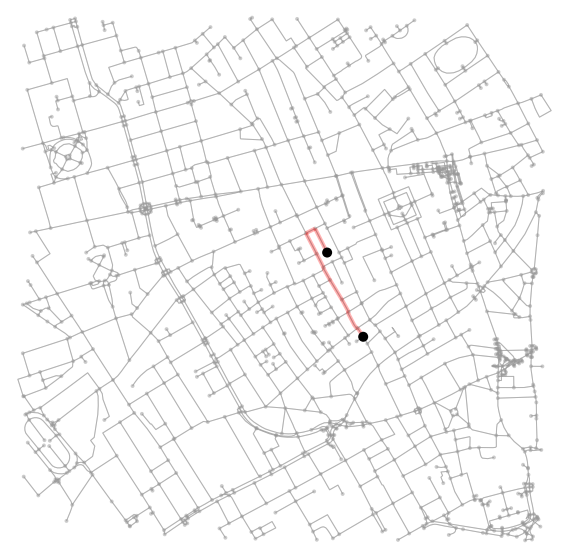

Random pair number 1, death node=25502545, pump_node=348875443


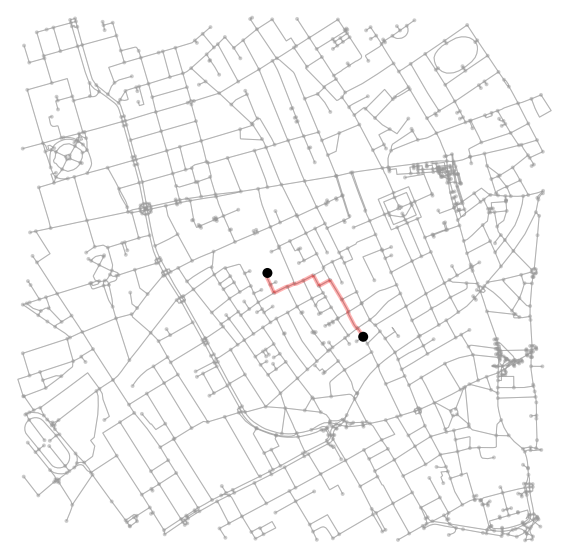

Random pair number 2, death node=1324710127, pump_node=348875443


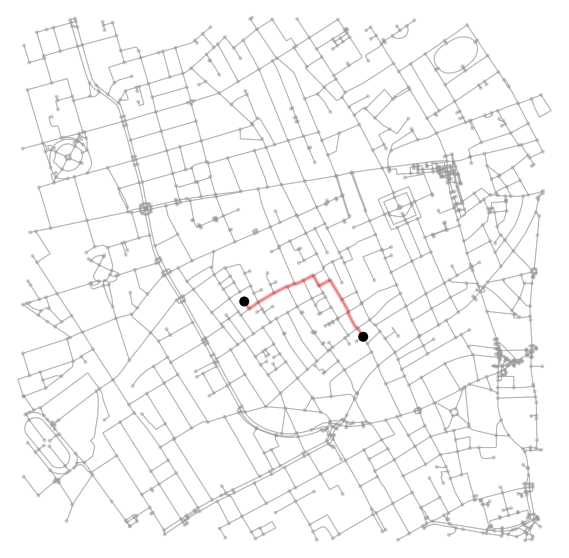

Random pair number 3, death node=2784682639, pump_node=348875443


In [55]:
import numpy as np

pump_node = np.random.choice(routes2_df['PNODE'])
for i in range(3):
    death_node = np.random.choice(routes2_df['DNODE'].unique())
    route = nx.shortest_path(G, death_node, pump_node)
    fig, ax = ox.plot_graph_route(G, route, fig_height=10, \
                        node_alpha=0.5, edge_alpha=0.5, \
                        orig_dest_node_color='black', \
                        orig_dest_node_alpha=1,\
                        route_alpha=0.3)
    print("Random pair number "+str(i+1)+\
          ", death node="+str(death_node)+", pump_node="+str(pump_node))

In [56]:
routes2_df.to_pickle('resources/routes2_df.pickle')

You can re-run the code above to see more random pairs.

### Updating `pumps_df` with mean distance values from `d1 + d2 + d3`

Let's store the mean distances between each pump and death locations from `routes_df` to `pumps_df`.

In [57]:
for i in pumps_df.iterrows():
    mean_distance = \
        routes2_df.loc[routes_df['PNODE'] == i[1]['NODE']]['DISTANCE'].mean()
    pumps_df.at[i[0], 'MEAN_DISTANCE'] = mean_distance
    print("Pump "+str(i[0])+":\n ","Node ID: ",i[1]['NODE'].astype(int)\
          ,"\n","Mean Distance: ", mean_distance, "meters")


Pump 0:
  Node ID:  25473293 
 Mean Distance:  183.9158706551408 meters
Pump 1:
  Node ID:  21665926 
 Mean Distance:  258.01782890631273 meters
Pump 2:
  Node ID:  4684520654 
 Mean Distance:  342.39989338459606 meters
Pump 3:
  Node ID:  107807 
 Mean Distance:  354.641402005255 meters
Pump 4:
  Node ID:  348875443 
 Mean Distance:  289.56630910531595 meters
Pump 5:
  Node ID:  25473300 
 Mean Distance:  286.03214411040375 meters
Pump 6:
  Node ID:  1663004187 
 Mean Distance:  356.91823377355763 meters
Pump 7:
  Node ID:  25257692 
 Mean Distance:  306.5212361846594 meters


In [58]:
pumps_df

,FID,LON,LAT,GLON,GLAT,DISTANCE,NODE,MEAN_DISTANCE
0,250,-0.136668,51.513341,-0.136533,51.513391,10.882904,25473293,183.915871
1,251,-0.139586,51.513876,-0.139462,51.513861,8.746021,21665926,258.017829
2,252,-0.139671,51.514906,-0.139904,51.514855,17.076661,4684520654,342.399893
3,253,-0.131630,51.512354,-0.131466,51.512196,20.870820,107807,354.641402
4,254,-0.133594,51.512139,-0.133606,51.512189,5.593686,348875443,289.566309
5,255,-0.135919,51.511542,-0.135762,51.511404,18.794758,25473300,286.032144
6,256,-0.133962,51.510019,-0.133994,51.510125,11.951782,1663004187,356.918234
7,257,-0.138199,51.511295,-0.138178,51.511281,2.167033,25257692,306.521236


> What does the column `MEAN_DISTANCE` mean?

## Step 5: Create `folium` map to show which pumps have mean shortest walkable distance values to most death points

### Recreate Notebook 1 map and markers for pumps and deaths

In [59]:
import folium

# use the latitude and Longitude coordinates of the Soho District center
SOHO_COORDINATES = (51.513578, -0.136722)

locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

# Iterate through the rows of the cholera deaths data frame 
#    and add each cholera death to map1

map1 = folium.Map(location=SOHO_COORDINATES, zoom_start=17)

folium.TileLayer('cartodbpositron').add_to(map1)
for i in range(0, len(locationlist)):
    popup = folium.Popup('Location: '+'('+str(locationlist[i][0])+\
                         ', '+str(locationlist[i][1])+')'+\
                         '<br/>'+\
                        'Deaths: '+ str(radiuslist[i][0]))
    folium.RegularPolygonMarker(locationlist[i], \
                        fill_color="red", \
                        number_of_sides=12, \
                        popup=popup, \
                        radius=radiuslist[i]).add_to(map1) 

# iterate through the rows of the pumps data frame and 
#   add each water pump to map1
for each in pumps_df.iterrows():
    popup = folium.Popup('Pump ID: '+str(each[1]['FID'].astype(int))+\
                         '<br/>'+\
                         'Location: '+'('+str(each[1]['LAT'])+\
                         ', '+str(each[1]['LON'])+')')
    #add each water pump to map1
    folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                        fill_color='blue', \
                        number_of_sides=4, \
                        popup=popup, \
                        radius=10).add_to(map1)

map1

Let's now identify which pump has the shortest walkable distance (filter=400 meters) from death locations.

In [60]:
for each in pumps_df.iterrows():
    #add each water pump to map1
    folium.Circle(location=[each[1]['LAT'],each[1]['LON']], \
                  popup='Pump '+str(each[1]['NODE'].astype(int)), \
                  radius=(each[1]['MEAN_DISTANCE'])/5).add_to(map1)
map1 

## Putting it All Together

Now that you have read all the narratives and code explanations, and seen the outputs of all the code, we can put all these together into one "program".

In [61]:
import pandas as pd
import folium
import osmnx as ox
import networkx as nx
import numpy as np

# set some configuration parameters for osmnx
# print version of package
ox.config(use_cache=True, log_console=True)
ox.config(log_file=True, log_console=True, use_cache=True)

deaths_df = pd.read_csv('resources/cholera_deaths.csv')
pumps_df = pd.read_csv('resources/johnsnow_pumps.csv')

SOHO_COORDINATES = (51.513578, -0.136722)

map1 = folium.Map(location=SOHO_COORDINATES, zoom_start=17)

folium.TileLayer('cartodbpositron').add_to(map1)

locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

for i in range(0, len(locationlist)):
    popup = folium.Popup('Location: '+'('+str(locationlist[i][0])+\
                         ', '+str(locationlist[i][1])+')'+\
                         '<br/>'+\
                        'Deaths: '+ str(radiuslist[i][0]))
    folium.RegularPolygonMarker(locationlist[i], \
                                fill_color="red", \
                                number_of_sides=12, \
                                popup=popup, \
                                radius=radiuslist[i]).add_to(map1) 

for each in pumps_df.iterrows():
    popup = folium.Popup('Location: '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')')
    #add each water pump to map1
    folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                                fill_color='blue', \
                                number_of_sides=4, \
                                popup=popup, \
                                radius=10).add_to(map1)

# Add mean center marker weighted by deaths
deaths_df['product_LAT'] = deaths_df['LAT'] * deaths_df['DEATHS']
deaths_df['product_LON'] = deaths_df['LON'] * deaths_df['DEATHS']

# Let's copy this dataframe to a new one which we can save (pickle)
mean_center_df = deaths_df

mean_LON = np.sum(deaths_df['product_LON'])/np.sum(deaths_df['DEATHS'])
mean_LAT = np.sum(deaths_df['product_LAT'])/np.sum(deaths_df['DEATHS'])
mean_center_POINT = (mean_LAT, mean_LON)

folium.RegularPolygonMarker(mean_center_POINT, \
                                fill_color="yellowgreen", \
                                number_of_sides=12, \
                                popup=folium.Popup('Mean Center Point: '+\
                                                   str(mean_center_POINT)), \
                                radius=10).add_to(map1)

G = ox.load_graphml(filename='soho.graphml', folder='resources')

pumps_df = pumps_df[['LON', 'LAT']]
pumps_df['GLON'] = 0.00
pumps_df['GLAT'] = 0.00
pumps_df['DISTANCE'] = 0.00
pumps_df['NODE'] = 0
pumps_df['NODE'].astype(int)
pumps_df['MEAN_DISTANCE'] = 0.00

for i in pumps_df.iterrows():
    pnode, pdistance = \
       ox.get_nearest_node(G, (i[1]['LAT'],i[1]['LON']), return_dist=True)
    pumps_df.at[i[0], 'GLON'] = G.node[pnode]['x']
    pumps_df.at[i[0], 'GLAT'] = G.node[pnode]['y']
    pumps_df.at[i[0], 'DISTANCE'] = pdistance # distance is provided in meters
    pumps_df.at[i[0], 'NODE'] = pnode

deaths_df = deaths_df[['DEATHS', 'LON', 'LAT']]
deaths_df['DEATHS'].astype(int)
deaths_df['GLON'] = 0.00
deaths_df['GLAT'] = 0.00
deaths_df['DISTANCE'] = 0.00
deaths_df['NODE'] = 0
deaths_df['NODE'].astype(int)

for i in deaths_df.iterrows():
    dnode, ddistance = ox.get_nearest_node(G, \
                    (i[1]['LAT'],i[1]['LON']), \
                    return_dist=True)
    deaths_df.at[i[0], 'GLON'] = G.node[dnode]['x']
    deaths_df.at[i[0], 'GLAT'] = G.node[dnode]['y']
    deaths_df.at[i[0], 'DISTANCE'] = ddistance
    deaths_df.at[i[0], 'NODE'] = dnode

# create empty list, lst, to store node and distance data 
#    from pairwise matching
lst = []

# carry out pairwise calculations
for i in pumps_df.iterrows():
    for j in deaths_df.iterrows():
        dnode = j[1]['NODE'].astype(int)
        pnode = i[1]['NODE'].astype(int)
        distance = \
            nx.shortest_path_length(G, dnode, pnode, weight='length') + \
            j[1]['DISTANCE'] + i[1]['DISTANCE']
        lst.append([dnode, pnode, distance])
        
columns = ['DNODE','PNODE','DISTANCE']
routes_df = pd.DataFrame(lst, columns=columns)

routes2_df = routes_df[routes_df['DISTANCE']<400]

for i in pumps_df.iterrows():
    mean_distance = \
        routes2_df.loc[routes_df['PNODE'] == i[1]['NODE']]['DISTANCE'].mean()
    pumps_df.at[i[0], 'MEAN_DISTANCE'] = mean_distance

for each in pumps_df.iterrows():
    #add each water pump to map1
    folium.Circle(location=[each[1]['LAT'],each[1]['LON']], \
                  popup='Pump '+str(each[1]['NODE'].astype(int)), \
                  radius=(each[1]['MEAN_DISTANCE'])/5).add_to(map1)
    
map1

## Congratulations!

You have just gained some expertise in:
1. The Cholera Outbreak in 1854 London
2. Use of a few Python packages for data analysis and visualization: `pandas`, `folium`
3. Use of the Open Street Maps - NetworkX package, `osmnx` for street network type analysis
4. Generating value out of information sources (mortality and street network data)

## References

1. Boeing, Geoff. OSMnx: Python for Street Networks. URL: https://geoffboeing.com/2016/11/osmnx-python-street-networks/
2. Networkx. URL: https://networkx.github.io/
3. Shiode S. Revisiting John Snow's map: network-based spatial demarcation of cholera area. International Journal of Geographical Information Science Volume 26, 2012 - Issue 1. URL: https://www.tandfonline.com/doi/abs/10.1080/13658816.2011.577433.

*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*